In [1]:
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from pandas_datareader import data
from datetime import date, datetime, timedelta

from math import gamma
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.distributions.empirical_distribution import ECDF 

#from multiprocessing import Pool, cpu_count
#from functools import partial
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark") 

In [4]:
def mle(s, 
        dist= "t",
        mm  = 0,
        dx  = 0.05):
    '''
    Best-Fit approximation of t-Student or Normal distribution using Maximum Likelihood Estimation of parameters 
    '''
    x = np.arange(s.min()-mm, s.max()+mm, dx)
    if dist == "n":
        n_mu, n_sigma = stats.norm.fit( s )
        n_pdf = stats.norm.pdf(x, n_mu, n_sigma)
        return dict({'mu': n_mu, 'sigma': n_sigma, 'pdf': n_pdf, 'x': x, 'dx': dx})
    elif dist == "t":
        t_degf, t_mu, t_sigma = stats.t.fit( s )
        t_pdf = stats.t.pdf(x, t_degf, t_mu, t_sigma)
        return dict({'degf':  t_degf, 'mu': t_mu, 'sigma': t_sigma, 'pdf': t_pdf, 'x': x, 'dx': dx})
    
def mc_test_stats(FH, 
                  size      = 1000, 
                  mcsamples = 1000,
                  dtype     = "t"):
    KS = []
    AD = []
    
    for k in range(mcsamples):
        
        if dtype == "t":
            # STEP 1, 2, and 3: simulate a new sample given the t-Student F_H distribution
            u = np.random.random(size=size)
            sample = pd.Series( stats.t(df=FH["degf"], loc=FH["mu"], scale=FH["sigma"]).ppf(u) )
            
            # STEP 4: fit the new sample via MLE
            df, mu, std = stats.t.fit(sample)
            FH_hat = pd.Series(np.sort( stats.t.cdf(sample, df=df, loc=mu, scale=std)), index=np.sort(sample))
        
        elif dtype == "n":
            # STEP 1, 2, and 3: simulate a new sample given the t-Student F_H distribution
            u = np.random.random(size=size)
            sample = pd.Series( stats.norm(loc=FH["mu"], scale=FH["sigma"]).ppf(u) )

            # STEP 4: fit the new sample via MLE
            mu, std = stats.norm.fit(sample)
            FH_hat = pd.Series(np.sort( stats.norm.cdf(sample, loc=mu, scale=std)), index=np.sort(sample))
            
        # STEP 5: computing the ECDF of the sample
        FE_hat = ECDF(sample) 
        FE_hat = pd.Series(FE_hat.y, index=FE_hat.x)
        FE_hat = FE_hat.drop(index=FE_hat.index[0])

        # STEP 6: computing the test statistic (KS and AD) 
        KS.append( max( abs(FE_hat - FH_hat) ) )
        AD.append( max( abs(FE_hat - FH_hat).divide(np.sqrt(FH_hat.multiply(1 - FH_hat))) ) )
    
        # STEP 7: the loop is repeated "mcsamples" times

    KS = pd.Series(KS)
    AD = pd.Series(AD)
    
    return KS, AD

'''
def get_empirical_cdf(data):
    F_ecdf = ECDF(data)    
    F_emp = pd.Series(F_ecdf.y, index=F_ecdf.x, name="Empirical CDF")
    F_emp = F_emp.drop(index=F_emp.index[0])
    return F_emp

def get_hypothetical_cdf(data, 
                         dist, 
                         distype = "t"):
    if distype == "n":
        return pd.Series(np.sort(stats.norm.cdf(data, loc=dist["mu"], scale=dist["sigma"])), 
                         index=np.sort(data), 
                         name="Fitted Normal CDF")  
    elif distype == "t":
        return pd.Series(np.sort(stats.t.cdf(data, df=dist["degf"], loc=dist["mu"], scale=dist["sigma"])), 
                         index=np.sort(data),
                         name="Fitted t-Student CDF")
    
def stattest(F_E, F_H, testype="KS"):
    if testype == "KS":
        return max( abs( F_E - F_H ) ) 
    elif testype == "AD":
        return max( abs( F_E - F_H ).divide( np.sqrt(F_H.multiply(1 - F_H)) ) ) 

def test_statistic(sample_data, 
                   fitted_dist, 
                   test_stat_dist, 
                   test = "AD", 
                   distype = "t"):
    # Computing the ECDF
    F_E = get_empirical_cdf(sample_data)
    
    # Computing the Hypothetical CDF  
    F_H = get_hypothetical_cdf(sample_data, 
                               fitted_dist, 
                               distype=distype) 
        
    if test == "AD":
        # Computing the AD test statistics 
        test_stat = AD_test(F_E, F_H)     
    elif test == "KS":
        # Computing the KS test statistics 
        test_stat = KS_test(F_E, F_H) 

    # Computing the corresponding p-value of the test statistic
    pvalue = ECDF(test_stat_dist)( test_stat )
    
    return test_stat, pvalue
'''

# t-Student 

def Gamma(x):
    return gamma(x) if x != 0 else 0

def tstudentstd(x, df=3):
    '''
    Standardized t-Student, i.e., having zero mean and unit variance
    '''
    return 1/np.sqrt((np.pi*(df-2)))*Gamma(0.5*(df+1))/Gamma(0.5*df)*(1+(x**2)/(df-2))**(-0.5*(df+1))


def tstudent(x, df=3):
    '''
    Standard t-Student, i.e., having zero mean and variance equal to df/(df-2)
    '''
    return 1/np.sqrt((np.pi*df))*Gamma(0.5*(df+1))/Gamma(0.5*df)*(1+(x**2)/df)**(-0.5*(df+1))


def gentstudent(mm, MM, df=3, std=True, dx=0.01):
    '''
    Generate t-Student PDF
    - std = True generate the 'standardized' distribution, i.e., having zero mean and unit variance
    - std = False generates the 'standard' distribution, i.e., having zero mean and variance equal to df/df-2
    '''
    xx = np.arange(mm, MM, dx)
    if std:
        tt = [tstudentstd(x, df=df) for x in xx]
    else:
        tt = [tstudent(x, df=df) for x in xx]        
    return pd.Series(tt, index=xx)


# Normal

def stdnormal(x, mu=0, std=1):
    return stats.norm.pdf(x, loc=mu, scale=std)


def gennormal(mm, MM, mu=0, std=1, dx=0.01):
    xx = np.arange(mm, MM, dx)
    nn = [stdnormal(x, mu=mu, std=std) for x in xx]
    return pd.Series(nn, index=xx)

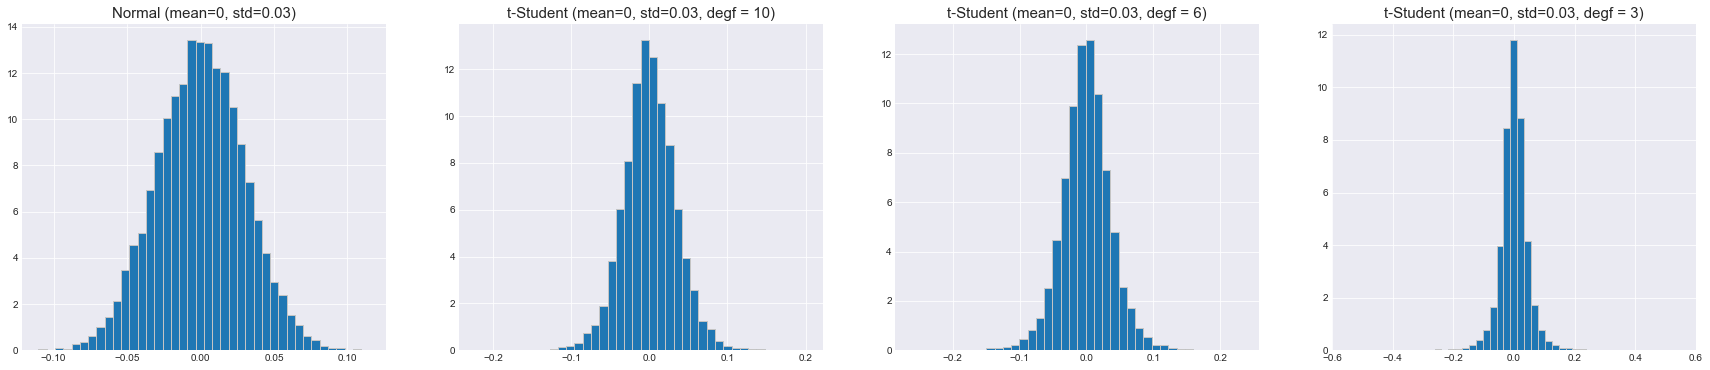

In [5]:
nsamples = 10000
mu  = 0
std = 0.03 

u = np.random.random(size=nsamples)
nn = pd.Series( stats.norm(loc=mu, scale=std).ppf(u) )

nu1 = 10
u = np.random.random(size=nsamples)
tt1 = pd.Series( stats.t(loc=mu, scale=std, df=nu1).ppf(u) )

nu2 = 6
u = np.random.random(size=nsamples)
tt2 = pd.Series( stats.t(loc=mu, scale=std, df=nu2).ppf(u) )

nu3 = 3
u = np.random.random(size=nsamples)
tt3 = pd.Series( stats.t(loc=mu, scale=std, df=nu3).ppf(u) )


# Plot
fig, ax = plt.subplots(1,4,figsize=(30,6))
ax = ax.flatten()
bins = 40
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=8) 
grey = .77, .77, .77


n=0
nn.hist(ax=ax[n], bins=bins, density=True, edgecolor=grey)
ax[n].set_title("Normal (mean={:.0f}, std={:.2f})".format(mu,std))
#ax[n].set_xlim([-0.5, 0.5])

n=1
tt1.hist(ax=ax[n], bins=bins, density=True, edgecolor=grey)
ax[n].set_title("t-Student (mean={:.0f}, std={:.2f}, degf = {:.0f})".format(mu,std,nu1))
#ax[n].set_xlim([-0.5, 0.5])

n=2
tt2.hist(ax=ax[n], bins=bins, density=True, edgecolor=grey)
ax[n].set_title("t-Student (mean={:.0f}, std={:.2f}, degf = {:.0f})".format(mu,std,nu2))
#ax[n].set_xlim([-0.5, 0.5])

n=3
tt3.hist(ax=ax[n], bins=bins+50, density=True, edgecolor=grey)
ax[n].set_title("t-Student (mean={:.0f}, std={:.2f}, degf = {:.0f})".format(mu,std,nu3))
ax[n].set_xlim([-0.6, 0.6])

plt.show()

In [6]:
nsamples = 10000
mu  = 0
std = 0.03 

'''
u = np.random.random(size=nsamples)
nn = pd.Series( stats.norm(loc=mu, scale=std).ppf(u) )
nnc = mle(nn.values, dist="n", dx=0.001, mm=0.15)
'''
nnc = stats.norm.rvs(loc=mu, scale=std, size=nsamples)
nnc = mle(nnc, dist="n", dx=0.001, mm=0.15)

nu1 = 10
'''
u = np.random.random(size=nsamples)
tt1 = pd.Series( stats.t(loc=mu, scale=std, df=nu1).ppf(u) )
tt1c = mle(tt1.values, dist="t", dx=0.001, mm=0.15)
'''
tt1c = stats.t.rvs(loc=mu, scale=std, df=nu1, size=nsamples)
tt1c = mle(tt1c, dist="t", dx=0.001, mm=0.15)


nu2 = 5
'''
u = np.random.random(size=nsamples)
tt2 = pd.Series( stats.t(loc=mu, scale=std, df=nu2).ppf(u) )
tt2c = mle(tt2.values, dist="t", dx=0.001, mm=0.10)
'''
tt2c = stats.t.rvs(loc=mu, scale=std, df=nu2, size=nsamples)
tt2c = mle(tt2c, dist="t", dx=0.001, mm=0.10)


nu3 = 2
'''
u = np.random.random(size=nsamples)
tt3 = pd.Series( stats.t(loc=mu, scale=std, df=nu3).ppf(u) )
tt3c = mle(tt3.values, dist="t", dx=0.001, mm=0)
'''
tt3c = stats.t.rvs(loc=mu, scale=std, df=nu3, size=nsamples)
tt3c = mle(tt3c, dist="t", dx=0.001, mm=0)


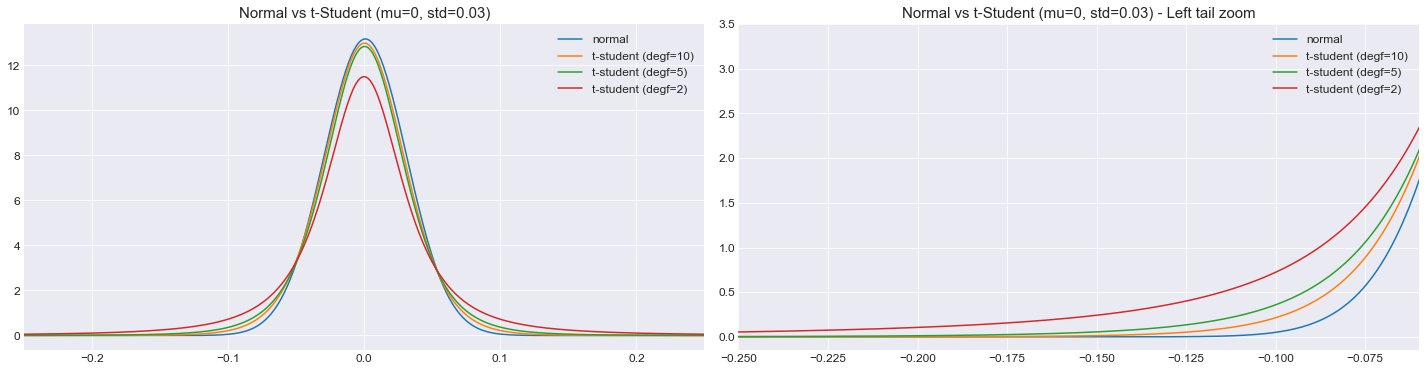

In [7]:
# Plot
fig, ax = plt.subplots(1,2,figsize=(25,6))
ax = ax.flatten()
bins = 40
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 

plt.subplots_adjust(wspace=0.05)

n = 0
ax[n].plot(nnc["x"], nnc["pdf"], label="normal")
ax[n].plot(tt1c["x"], tt1c["pdf"], label="t-student (degf={:.0f})".format(nu1))
ax[n].plot(tt2c["x"], tt2c["pdf"], label="t-student (degf={:.0f})".format(nu2))
ax[n].plot(tt3c["x"], tt3c["pdf"], label="t-student (degf={:.0f})".format(nu3))
ax[n].legend()
ax[n].grid()
ax[n].set_xlim(-0.25, 0.25)
ax[n].set_title("Normal vs t-Student (mu={:.0f}, std={:.2f})".format(mu, std))

n = 1
ax[n].plot(nnc["x"], nnc["pdf"], label="normal")
ax[n].plot(tt1c["x"], tt1c["pdf"], label="t-student (degf={:.0f})".format(nu1))
ax[n].plot(tt2c["x"], tt2c["pdf"], label="t-student (degf={:.0f})".format(nu2))
ax[n].plot(tt3c["x"], tt3c["pdf"], label="t-student (degf={:.0f})".format(nu3))
ax[n].legend()
ax[n].grid()
ax[n].set_xlim(-0.25, -0.06)
ax[n].set_ylim(-0.15, 3.5)
ax[n].set_title("Normal vs t-Student (mu={:.0f}, std={:.2f}) - Left tail zoom".format(mu, std))


plt.show()

## Normal vs Standardized t-Student (unit variance)

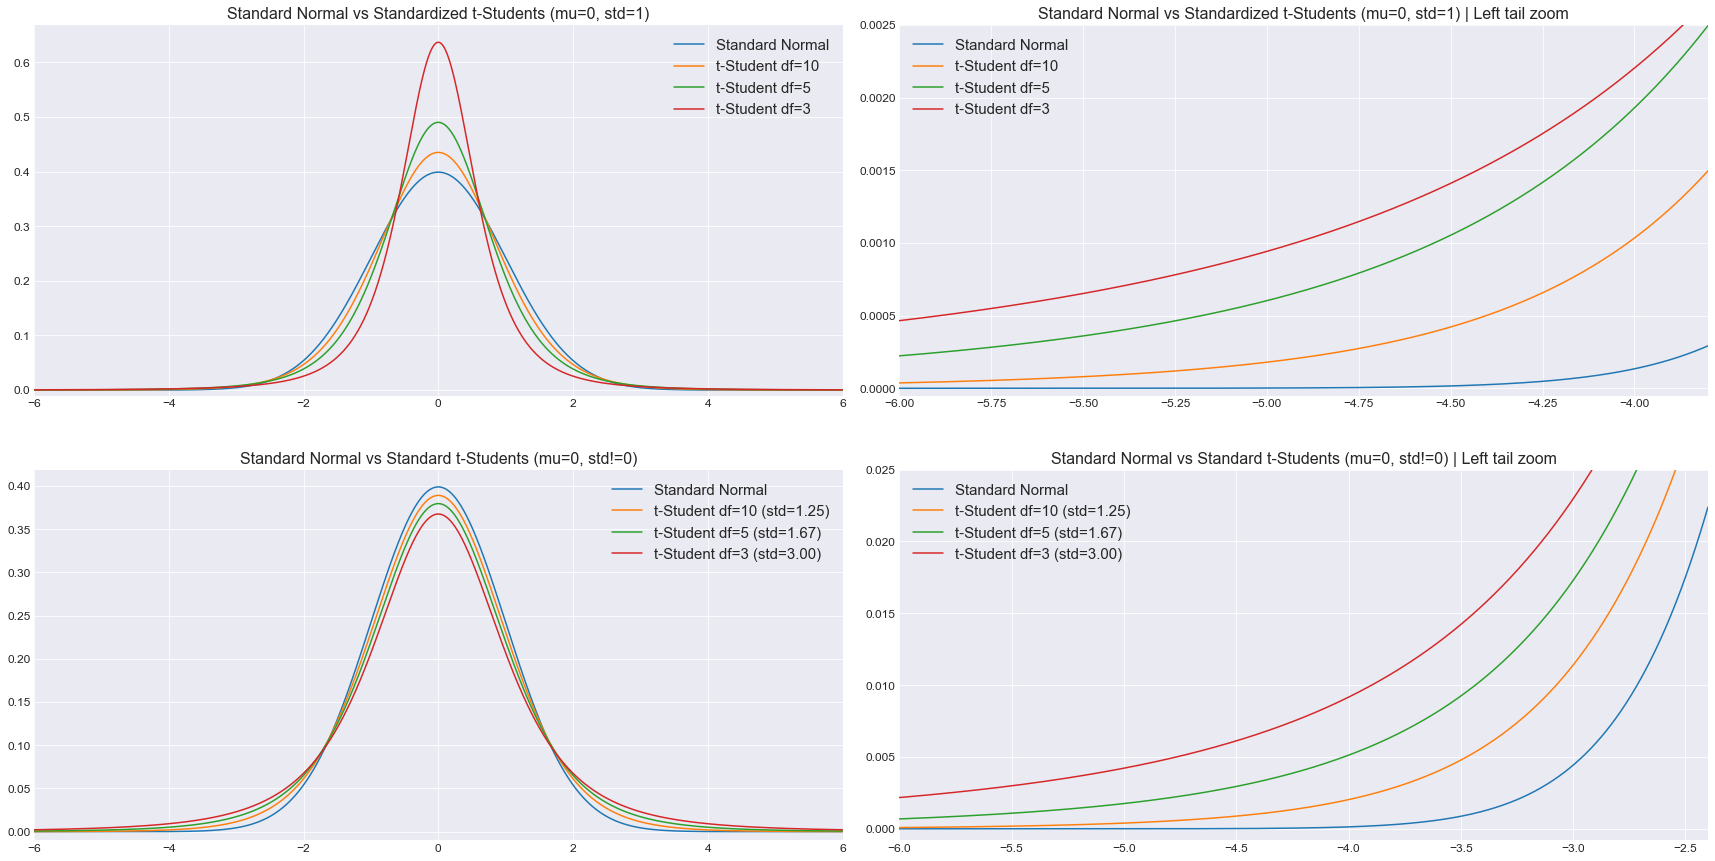

In [8]:
mm = -6
MM = -mm
mu = 0
ss = 1
dx = 0.001
df1 = 10
df2 = 5
df3 = 3

nn = gennormal(mm, MM, mu=mu, std=ss, dx=dx)

# Standardized t-student (with unit variance)
ttstd1 = gentstudent(mm, MM, df=df1, std=True, dx=dx)
ttstd2 = gentstudent(mm, MM, df=df2, std=True, dx=dx)
ttstd3 = gentstudent(mm, MM, df=df3, std=True, dx=dx)

# Standard t-student (not unit variance)
tt1 = gentstudent(mm, MM, df=df1, std=False, dx=dx)
tt2 = gentstudent(mm, MM, df=df2, std=False, dx=dx)
tt3 = gentstudent(mm, MM, df=df3, std=False, dx=dx)


# Plot
fig, ax = plt.subplots(2,2,figsize=(30,15))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.07)
plt.rc('axes', titlesize=16) 
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=14)   
plt.rc('ytick', labelsize=14)  
plt.rc('legend', fontsize=15) 

# Standardized t-student (not unit variance)
k = 0
nn.plot(ax=ax[k], label="Standard Normal")
ttstd1.plot(ax=ax[k], grid=True, label="t-Student df={:.0f}".format(df1))
ttstd2.plot(ax=ax[k], grid=True, label="t-Student df={:.0f}".format(df2))
ttstd3.plot(ax=ax[k], grid=True, label="t-Student df={:.0f}".format(df3))
ax[k].legend()
ax[k].set_xlim(mm,MM)
ax[k].set_ylim(bottom=-0.01)
ax[k].set_title("Standard Normal vs Standardized t-Students (mu={:.0f}, std={:.0f})".format(mu, ss))

k = k+1
nn.plot(ax=ax[k], label="Standard Normal")
ttstd1.plot(ax=ax[k], grid=True, label="t-Student df={:.0f}".format(df1))
ttstd2.plot(ax=ax[k], grid=True, label="t-Student df={:.0f}".format(df2))
ttstd3.plot(ax=ax[k], grid=True, label="t-Student df={:.0f}".format(df3))
ax[k].legend()
ax[k].set_xlim(mm, -3.8)
ax[k].set_ylim(bottom=-0.00005, top=0.0025)
ax[k].set_title("Standard Normal vs Standardized t-Students (mu={:.0f}, std={:.0f}) | Left tail zoom".format(mu, ss))


# Standard t-student (not unit variance)
k = k+1
nn.plot(ax=ax[k], label="Standard Normal")
tt1.plot(ax=ax[k], grid=True, label="t-Student df={:.0f} (std={:.2f})".format(df1,df1/(df1-2)))
tt2.plot(ax=ax[k], grid=True, label="t-Student df={:.0f} (std={:.2f})".format(df2,df2/(df2-2)))
tt3.plot(ax=ax[k], grid=True, label="t-Student df={:.0f} (std={:.2f})".format(df3,df3/(df3-2)))
ax[k].legend()
ax[k].set_xlim(mm,MM)
ax[k].set_ylim(bottom=-0.01)
ax[k].set_title("Standard Normal vs Standard t-Students (mu={:.0f}, std!=0)".format(mu))

k = k+1
nn.plot(ax=ax[k], label="Standard Normal")
tt1.plot(ax=ax[k], grid=True, label="t-Student df={:.0f} (std={:.2f})".format(df1,df1/(df1-2)))
tt2.plot(ax=ax[k], grid=True, label="t-Student df={:.0f} (std={:.2f})".format(df2,df2/(df2-2)))
tt3.plot(ax=ax[k], grid=True, label="t-Student df={:.0f} (std={:.2f})".format(df3,df3/(df3-2)))
ax[k].legend()
ax[k].set_xlim(mm, -2.4)
ax[k].set_ylim(bottom=-0.0008, top=0.025)
ax[k].set_title("Standard Normal vs Standard t-Students (mu={:.0f}, std!=0) | Left tail zoom".format(mu))

plt.show()

In [9]:
import numpy as np

In [10]:
from scipy.signal import argrelextrema

In [2]:
def getassets(tickers, 
              startdate = "2011-12-31", 
              enddate   = "2022-12-31", 
              datatype  = "Adj Close",
              dsource   = "yahoo"):
    try:
        # Firstly, try with pandas datareader
        assets = yf.download(tickers = tickers,
                             start = startdate,
                             end = enddate,
                             progress = False)
        if len(tickers) > 1:
            assets.index   = assets.index.tz_localize(None)      # change yf date format to match pdr (pandas datareader)
            assets         = assets.filter(like = datatype)      # reduce to just selected columns
            assets.columns = assets.columns.get_level_values(1)  # tickers as col names
        else:
            assets = assets.filter(like = datatype)                # reduce to just selected columns
            assets = assets.rename(columns={datatype:tickers[0]})  # tickers as col names

    except:
        print("YF-ERROR: cannot download data using yahoo-finance")
        print("Trying with Pandas DataReader")
        # If yahoo finance does not work, use pandas datareader
        syy, smm, sdd = startdate.split("-")
        eyy, emm, edd = enddate.split("-")
        assets = pd.DataFrame()
        for i,asset_name in enumerate(tickers):
            print("- Loading {} ({:.0f}/{:.0f})\t".format(asset_name,i+1,len(tickers)))
            assets[asset_name] = data.DataReader(asset_name, 
                                                 data_source = dsource,
                                                 start = datetime(int(syy),int(smm),int(sdd)), 
                                                 end = datetime(int(eyy),int(emm),int(edd)))[datatype]   
    return assets

## Load data

In [3]:
tickers   = ["MSFT","KO","AAPL","AMZN","NFLX","GOOG","GE","IBM"]
startdate = "2011-12-31" #datetime(2011,12,31)
enddate   = "2022-12-31" #datetime(2022,12,31)
mpor      = 1
bins      = 80
grey      = .77, .77, .77

In [4]:
# Dataframe of price data
assets = getassets(tickers, startdate=startdate, enddate=enddate, datatype="Adj Close")

In [5]:
# Dataframe of MPOR-days returns
rets = (assets / assets.shift(mpor)  - 1).dropna()

In [15]:
assets

,AAPL,AMZN,GE,GOOG,IBM,KO,MSFT,NFLX
Date,,,,,,,,
2012-01-03,12.500192,8.951500,86.231956,16.573130,117.096085,24.902029,21.413071,10.320000
2012-01-04,12.567370,8.875500,87.171310,16.644611,116.618370,24.745811,21.916992,11.492857
2012-01-05,12.706892,8.880500,87.124352,16.413727,116.065269,24.628647,22.140968,11.328571
2012-01-06,12.839730,9.130500,87.593994,16.189817,114.732796,24.472437,22.484922,12.327143
2012-01-09,12.819362,8.928000,88.580330,15.503389,114.135658,24.472437,22.188959,14.025714
...,...,...,...,...,...,...,...,...
2022-12-23,131.658981,85.250000,63.848557,89.809998,139.931198,63.820000,238.133545,294.959991
2022-12-27,129.831772,83.040001,64.668228,87.930000,140.691849,64.209999,236.367981,284.170013
2022-12-28,125.847855,81.820000,63.989071,86.459999,138.320984,63.570000,233.944031,276.880005


## Select one ticker

In [27]:
tick = "IBM"

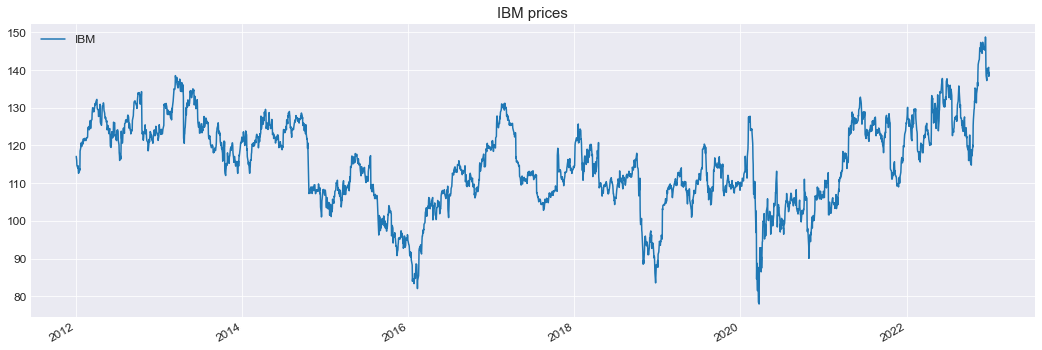

In [28]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(18,6))
#ax = ax.flatten()
bins = 40
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 

assets[[tick]].plot(ax=ax, grid=True)
ax.set_title("{} prices".format(tick))
ax.set_xlabel(None)
plt.show()

In [29]:
MM = assets[[tick]].cummax()
mm = assets[[tick]].cummin()

ddown = (assets[[tick]] - MM) / MM * 100
dup   = (assets[[tick]] - mm) / mm * 100

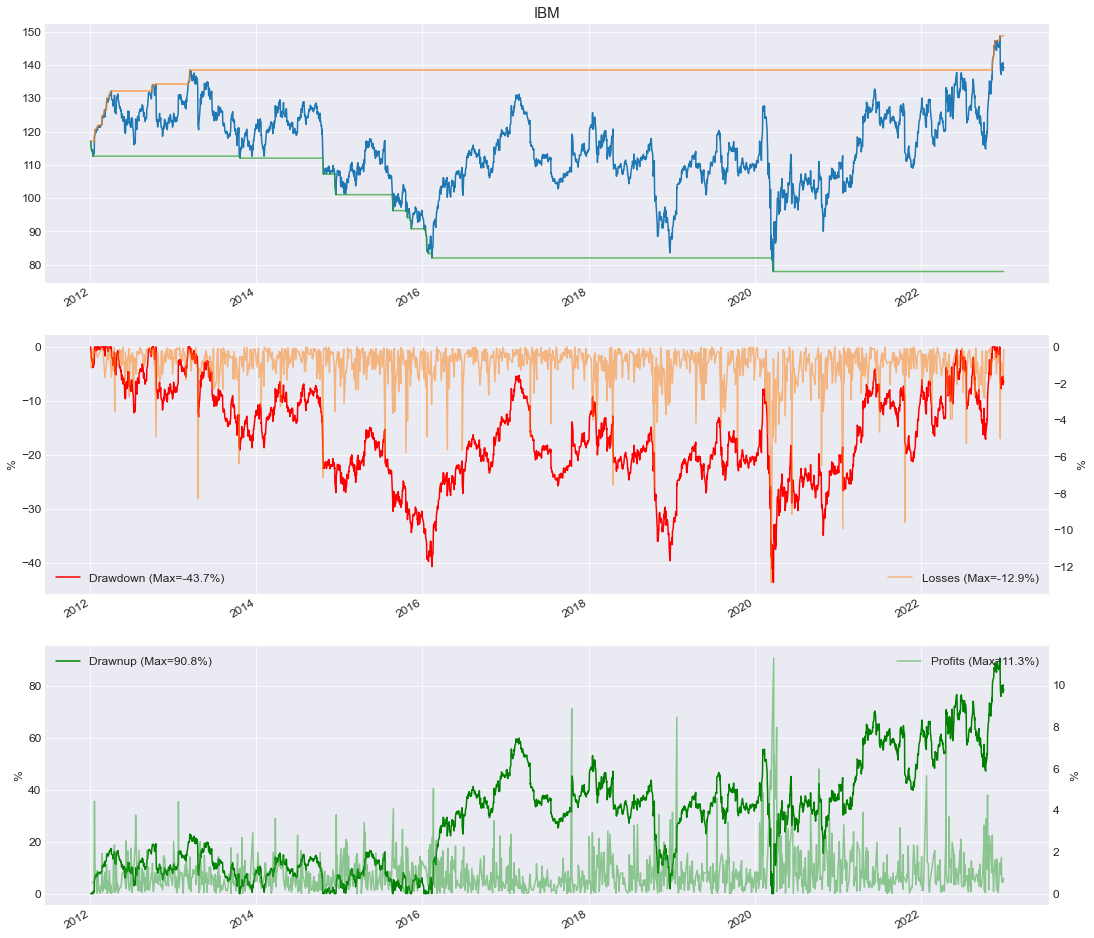

In [30]:
# Plot
fig, ax = plt.subplots(3,1,figsize=(18,18))
ax = ax.flatten()
bins = 40
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 

n = 0
assets[[tick]].plot(ax=ax[n], grid=True, logy=False)
MM.plot(ax=ax[n], grid=True, color="tab:orange", alpha=0.7)
mm.plot(ax=ax[n], grid=True,  color="tab:green", alpha=0.7)

ax[n].set_title("{}".format(tick))
ax[n].set_xlabel(None)
ax[n].legend("")

n = n+1
ddown[tick].plot(ax=ax[n], grid=True, color="red", label="Drawdown (Max={:.1f}%)".format(ddown[tick].min()))
ax[n].set_xlabel(None)
ax[n].set_ylabel("%")
ax[n].legend(loc="lower left")
#
ax2 = ax[n].twinx()
nr = rets[tick][rets[tick]<=0].copy()
(nr*100).plot(ax=ax2, grid=False, color="tab:orange",
              label="Losses (Max={:.1f}%)".format(nr.min()*100),
              alpha=0.5)
ax2.legend(loc="lower right")
ax2.set_ylabel("%")

n = n+1
dup[tick].plot(ax=ax[n], grid=True, color="green", label="Drawnup (Max={:.1f}%)".format(dup[tick].max()))
ax[n].set_xlabel(None)
ax[n].set_ylabel("%")
ax[n].legend(loc="upper left")
#
ax2 = ax[n].twinx()
pr = rets[tick][rets[tick]>=0].copy()
(pr*100).plot(ax=ax2, grid=False, color="tab:green",
              label="Profits (Max={:.1f}%)".format(pr.max()*100),
              alpha=0.5)
ax2.legend(loc="upper right")
ax2.set_ylabel("%")

plt.show()

In [31]:
order = 5
# Define a series to store the pivots / inflections
peaksidx = argrelextrema(assets[tick].values, np.greater, order=order)
throuidx = argrelextrema(assets[tick].values, np.less, order=order)

In [32]:
Peaks = assets[[tick]].reset_index().loc[peaksidx].set_index("Date")
Peaks["Type"] = 1
#Peaks["Returns"] = Peaks / Peaks.shift(mpor) - 1
Throu = assets[[tick]].reset_index().loc[throuidx].set_index("Date")
Throu["Type"] = -1

In [33]:
PT = pd.concat([Peaks, Throu], axis=0).sort_index().reset_index()
#PT

In [34]:
PT["Type"].sum()

-5

In [35]:
copies = []
for i in range(1,len(PT.index)):
    #if PT["Type"][i] == PT["Type"][i-1]:
    #    copies.append(i-1)
    try:
        if PT["Type"][i] == +1:
            aa = (PT["Type"][i] != PT["Type"][i-1]) and (PT["Type"][i] == PT["Type"][i+1])
            bb = (PT["Type"][i] == PT["Type"][i-1]) and (PT["Type"][i] == PT["Type"][i+1])
            if aa or bb:
                copies.append(i)                
        elif PT["Type"][i] == -1:
            bb = (PT["Type"][i] == PT["Type"][i-1]) and (PT["Type"][i] == PT["Type"][i+1])
            cc = (PT["Type"][i] == PT["Type"][i-1]) and (PT["Type"][i] != PT["Type"][i+1])
            if bb or cc:
                copies.append(i)
    except:
        pass

In [36]:
copies

[3,
 20,
 27,
 40,
 47,
 48,
 67,
 70,
 77,
 82,
 87,
 92,
 97,
 98,
 103,
 114,
 119,
 128,
 139,
 142,
 157,
 160,
 167,
 170,
 173,
 178,
 187,
 190,
 193,
 198,
 211,
 224,
 229,
 236,
 241,
 248,
 257,
 264,
 277,
 282,
 287,
 288,
 303,
 320,
 321,
 332]

In [37]:
len(copies)

46

In [38]:
#Throu[:"2012"]

In [39]:
PT.loc[copies]

,Date,IBM,Type
3,2012-03-16,129.988708,1
20,2012-10-05,134.005005,1
27,2012-12-14,122.556885,-1
40,2013-05-08,132.070908,1
47,2013-07-08,125.725929,1
48,2013-07-18,127.666832,1
67,2014-03-25,127.768684,1
70,2014-04-30,128.705505,1
77,2014-07-03,124.223137,1
82,2014-09-19,128.583298,1


In [40]:
#PT.loc[copies]["Type"].diff().fillna(0)

In [41]:
#diffs = PT.loc[copies]["Type"].diff().fillna(0)

In [42]:
#diffs[diffs == 0].index

In [43]:
#[idx for idx in diffs[diffs != 0].index[1:]] + [PT.loc[copies].index[-1]] 

In [44]:
#auxidx = pd.DataFrame([diffs[diffs != 0].index, [idx for idx in diffs[diffs != 0].index[1:]] + [PT.loc[copies].index[-1]] ]).T
#auxidx

In [45]:
#[tt for tt in PT["Type"][10:16]]

In [46]:
PT = PT.drop(copies, axis=0).set_index("Date")

In [47]:
PT["Type"].sum()

-1

In [48]:
PT.query("Type == 1")[tick]

Date
2012-02-09    121.861664
2012-04-03    132.190811
2012-04-17    130.897278
2012-05-02    131.282211
2012-06-15    126.154892
                 ...    
2022-10-05    122.750717
2022-10-28    135.217117
2022-11-22    147.290802
2022-12-13    148.742966
2022-12-27    140.691849
Name: IBM, Length: 145, dtype: float64

In [49]:
PT.query("Type == 1")[[tick]].copy()

,IBM
Date,
2012-02-09,121.861664
2012-04-03,132.190811
2012-04-17,130.897278
2012-05-02,131.282211
2012-06-15,126.154892
...,...
2022-10-05,122.750717
2022-10-28,135.217117
2022-11-22,147.290802


In [50]:
PT["Return"] = PT[tick] / PT[tick].shift(1) - 1

No handles with labels found to put in legend.


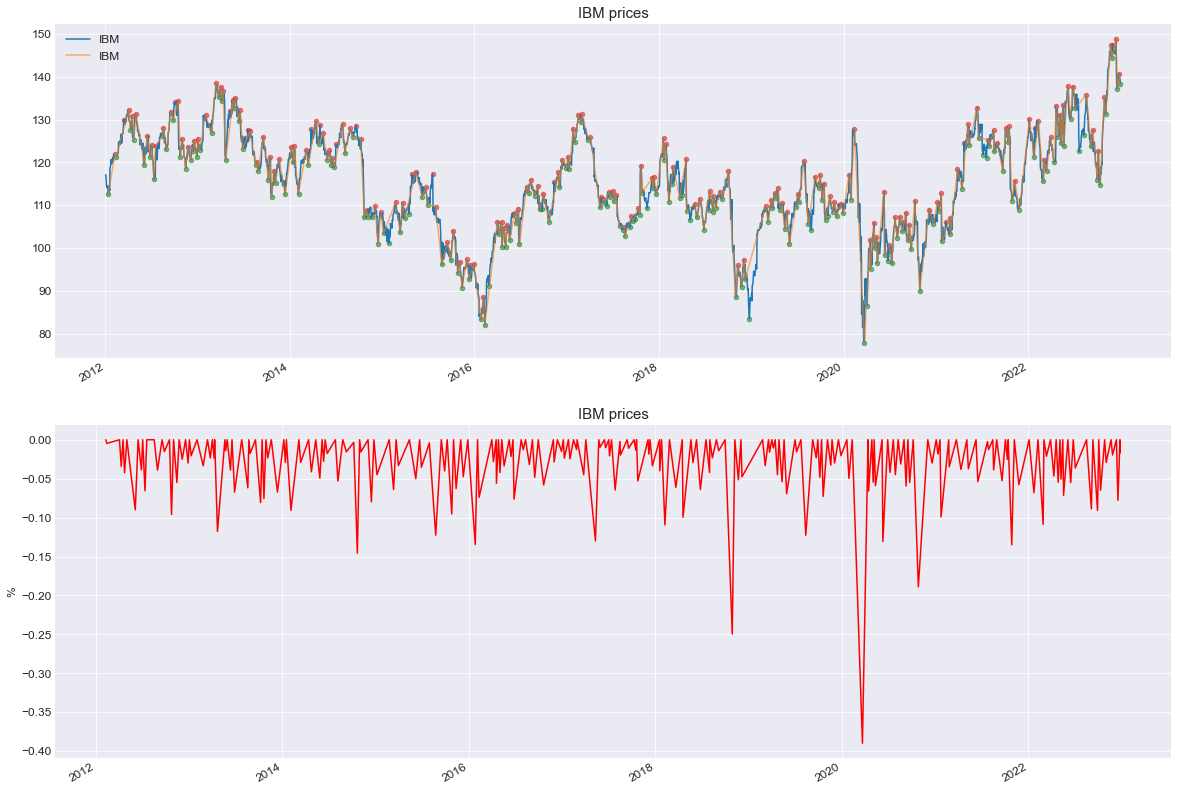

In [51]:
# Plot
fig, ax = plt.subplots(2,1,figsize=(20,15))
ax = ax.flatten()
bins = 40
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 

n = 0
assets[[tick]].plot(ax=ax[n], grid=True, logy=False)

# Plot all Peaks
ax[n].scatter(Peaks[[tick]].index, Peaks[[tick]].values, marker='o', color="red", alpha=0.5, s=20)
# Plot only "clear" peaks (isn repeticiones)
#auxpp = PT.query("Type == 1")[[tick]].copy()
#ax[n].scatter(auxpp.index, auxpp.values, marker='o', color="red", alpha=0.6, s=18)

# Plot all Through
ax[n].scatter(Throu[[tick]].index, Throu[[tick]].values, marker='o', color="green", alpha=0.5, s=20)
# Plot only "clear" through (sin repeticiones)
#auxtt = PT.query("Type == -1")[[tick]].copy()
#ax[n].scatter(auxtt.index, auxtt.values, marker='o', color="green", alpha=0.6, s=18)

PT[[tick]].plot(ax=ax[n], grid=True, color="tab:orange", alpha=0.6)
ax[n].set_title("{} prices".format(tick))
ax[n].set_xlabel(None)

n = n+1
np.minimum(0,PT["Return"]).plot(ax=ax[n], grid=True, color="red", label="")
#ddown[tick].plot(ax=ax[n], grid=True, color="red", label="Max Drawdown")
ax[n].set_title("{} prices".format(tick))
ax[n].set_xlabel(None)
ax[n].set_ylabel("%")
ax[n].legend(loc="lower left")

#ax2 = ax[n].twinx()
#rets[tick][rets[tick]<0].plot(ax=ax2, grid=False, color="tab:orange", label="Peak-to-Through (right axis)")
#pkthr[tick].plot(ax=ax2, grid=False, color="tab:orange", label="Peak-to-Through (right axis)")
#ax2.legend(loc="lower right")
#ax2.set_ylabel("%")

In [52]:
PT.loc[PT.index[PT["Return"].argmin()-1:PT["Return"].argmin()+1:]] 
#loc[PT["Return"].argmin()]

,IBM,Type,Return
Date,,,
2020-02-12,127.743172,1,0.147414
2020-03-23,77.948769,-1,-0.389801


In [53]:
PT

,IBM,Type,Return
Date,,,
2012-01-13,112.608292,-1,NaN
2012-02-09,121.861664,1,0.082173
2012-02-14,121.287491,-1,-0.004712
2012-04-03,132.190811,1,0.089896
2012-04-10,127.666725,-1,-0.034224
...,...,...,...
2022-11-28,144.406219,-1,-0.019584
2022-12-13,148.742966,1,0.030032
2022-12-19,137.184921,-1,-0.077705


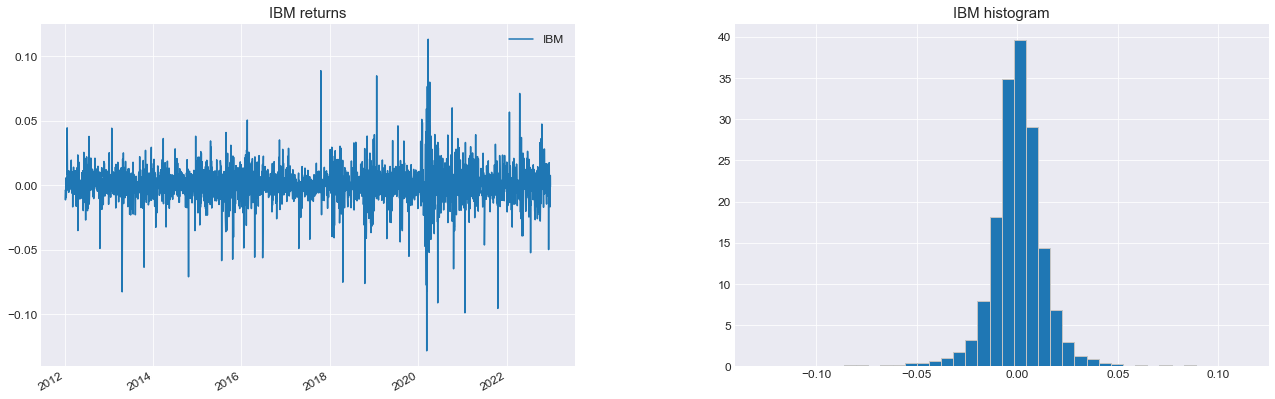

In [54]:
# Plot
fig, ax = plt.subplots(1,2,figsize=(22,7))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.05)
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 

n = 0
rets[[tick]].plot(ax=ax[n], grid=True)
ax[n].set_title("{} returns".format(tick))
ax[n].set_xlabel("")
#ax[1].set_xlabel("")

n = n+1
rets[[tick]].hist(ax=ax[n], grid=True, bins=bins, density=True, edgecolor=grey)
ax[n].set_title("{} histogram".format(tick))
ax[n].set_xlabel("")

plt.show()

In [55]:
round(rets.mean()*100, 2), round(rets.std()*100,2), round(rets.skew(),2), round(rets.kurt(),2)

(AAPL    0.10
 AMZN    0.10
 GE      0.01
 GOOG    0.07
 IBM     0.02
 KO      0.04
 MSFT    0.10
 NFLX    0.17
 dtype: float64,
 AAPL    1.83
 AMZN    2.05
 GE      2.04
 GOOG    1.69
 IBM     1.44
 KO      1.12
 MSFT    1.67
 NFLX    3.15
 dtype: float64,
 AAPL   -0.07
 AMZN    0.41
 GE      0.17
 GOOG    0.42
 IBM    -0.54
 KO     -0.67
 MSFT    0.03
 NFLX    0.80
 dtype: float64,
 AAPL     5.50
 AMZN     7.56
 GE       7.84
 GOOG     8.84
 IBM     10.27
 KO       9.84
 MSFT     8.65
 NFLX    24.93
 dtype: float64)

In [272]:
#rets[[tick]].sort_values(tick)

In [58]:
s = rets[[tick]].copy()

In [62]:
(1+s).prod()-1

IBM    0.1886
dtype: float64

In [67]:
s.tail(1).values[0] / s.head(1).values[0] - 1

array([-0.70459242])

In [120]:
from src import quant as qt
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
tickers   = ["MSFT","KO","AAPL","AMZN","NFLX","GOOG","GE","IBM"]
startdate = "2011-12-31" 
enddate   = "2022-12-31"

In [111]:
assets = qt.getassets(tickers, startdate=startdate, enddate=enddate, datatype="Adj Close")
#assets

In [112]:
rets = qt.compute_returns(assets, mpor=1, ascending=True, dropna=True)
#rets

In [113]:
#qt.compound(rets)

In [27]:
#qt.compound_returns(rets)

In [28]:
#qt.compute_logreturns(assets, mpor=5, ascending=True, dropna=True)

In [29]:
#qt.drawdown(assets, rets=False, maxd=True, percent=True)#.plot()

In [30]:
#qt.drawdown(assets, rets=False, maxd=True, percent=True)

In [31]:
#qt.drawdown(rets, rets=True, maxd=False, percent=True).plot()

In [32]:
#qt.drawdown(rets, rets=True, maxd=True, percent=True)

In [33]:
#qt.drawup(assets).plot()

In [34]:
#qt.is_normal(rets, siglev=0.05)

In [35]:
#qt.semistd(rets, negative=False)

In [36]:
#qt.annualize_returns(rets, ppy=252)

In [37]:
#qt.annualize_std(rets, ppy=252)

In [38]:
#qt.hvar(rets, CL=99/100) 
#qt.HVaR(rets, CL=99/100)
#qt.es(rets, CL=99/100)
#qt.ES(rets, CL=99/100)

In [39]:
#rets.kurt()
#qt.kurtosis(rets, excess=True)

In [40]:
#qt.hvar_normal(rets, CL=99/100, cf=False, ddof=1)

In [65]:
#qt.summary_stats(rets["AAPL"], CL=99/100)

In [90]:
#qt.summary_stats(rets, CL=99/100)

In [122]:
#qt.sample_cov(rets)
#qt.cc_cov(rets)
#qt.shrinkage_cov(rets, delta=0.3)

In [534]:
EMEF = pd.DataFrame()
EMEF["pu"] = np.linspace(1,100,100)
EMEF["uu"] = [rets[[tick]].quantile(q = probu/100).values[0] for probu in EMEF["pu"]]
#(pu, uu)

In [535]:
#aux = rets[[tick]].copy()
#aux["X-u"] = np.maximum(0, rets[[tick]] - uu)

In [536]:
#aux[tick].hist(bins=60)
#aux["X-u"].hist(bins=200)

In [537]:
# Empirical Mean Excess Function
emef = []
for u in EMEF["uu"]:
    extremes = rets[[tick]] - u
    num = np.maximum(0,extremes).sum().values[0]
    den = np.where(extremes>0)[0].shape[0]
    emef.append(np.nan if den == 0 else num / den)
EMEF["EMEF"] = emef

In [538]:
#EMEF

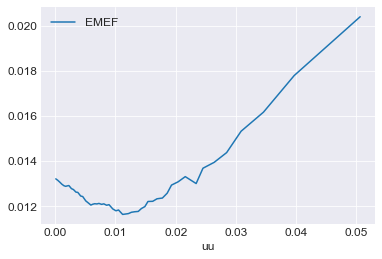

In [539]:
df = EMEF[["uu","EMEF"]].set_index("uu")
df.loc[0:].plot(grid=True)
plt.show()

In [540]:
# Find the event uu starting from which the EMEF plot is approximately linear 
theshold_uu = 0.03

# Then get the the corresponding quantile 
qtail = EMEF.loc[ EMEF.apply(lambda x: abs(x["uu"] - theshold_uu), axis=1).argmin() , "pu"]

print(f"Tail identified by x = {theshold_uu:.3f} ({qtail:.1f}%)")
#(qtail, theshold_uu)

Tail identified by x = 0.030 (96.0%)


In [541]:
u = rets[[tick]].quantile(q = qtail/100).values[0]
tail = rets[[tick]].query("{} > {}".format(tick,u))

# numero de datos de la cola vs total data (en %)
tail.shape[0] / rets[[tick]].shape[0] * 100

4.0115648717022045

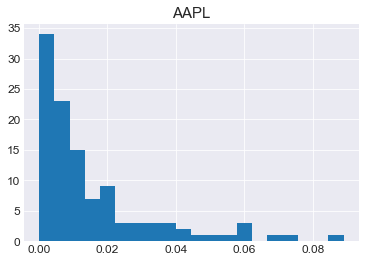

In [542]:
# Excesses
y = tail - u

y.hist(bins=20)
plt.show()

In [543]:
def mle(s, 
        dist= "t",
        mm  = 0,
        dx  = 0.05):
    '''
    Best-Fit approximation of t-Student or Normal distribution using Maximum Likelihood Estimation of parameters 
    '''
    x = np.arange(s.min()-mm, s.max()+mm, dx)
    if dist == "n":
        n_mu, n_sigma = stats.norm.fit( s )
        n_pdf = stats.norm.pdf(x, n_mu, n_sigma)
        return dict({'mu': n_mu, 'sigma': n_sigma, 'pdf': n_pdf, 'x': x, 'dx': dx})
    elif dist == "t":
        t_degf, t_mu, t_sigma = stats.t.fit( s )
        t_pdf = stats.t.pdf(x, t_degf, t_mu, t_sigma)
        return dict({'degf':  t_degf, 'mu': t_mu, 'sigma': t_sigma, 'pdf': t_pdf, 'x': x, 'dx': dx})
    elif dist == "gdp":
        # GDP pdf:
        # f = (1 + c*x)^(-1-1/c)
        # con c = shape parameter
        c, mu, std = stats.genpareto.fit( s )
        # Pero notar que calculando 
        # pdf = stats.genpareto.pdf(x, c, mu, std)
        # es equivalente a estandardizar utilizando la mu y la std 
        pdf = (1/std)*(1 + c/std*(x-mu))**(-1-1/c)
        return dict({'c':c, 'mu':mu, 'std':std, 'pdf':pdf, 'x': x, 'dx': dx})

In [544]:
# Fit Generalized Pareto Distribution GDP
gdpdist = mle(y[tick].values, dist="gdp", dx=0.0005)

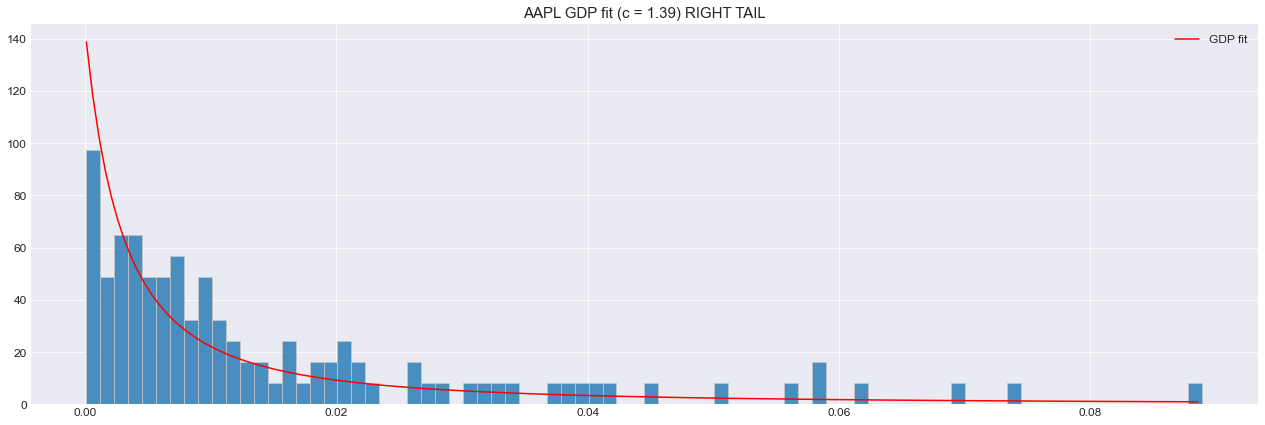

In [545]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(22, 7))
#ax = ax.flatten()
plt.subplots_adjust(wspace=0.05)
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 
bins = 80
grey = .77, .77, .77

n = 0
y.hist(ax=ax, grid=True, bins=bins, density=True, edgecolor=grey, alpha=0.8)
ax.set_title("{} GDP fit (c = {:.2f}) RIGHT TAIL".format(tick,gdpdist["c"]))
ax.plot(gdpdist["x"], gdpdist["pdf"], 'r', label="GDP fit")
ax.legend(loc="best")
plt.show() 

In [546]:
# Number of exceesses
Nu = y.shape[0]

# Total number of data
N = rets[[tick]].shape[0]

# GDP tail index parameter
xi = gdpdist["c"] 
# GDP scale parameters
beta = gdpdist["std"]

CL = 99

In [549]:
# Shock de la right tail con POT 
potshock = u + (beta/xi)*( ((1-CL/100)*N/Nu)**(-xi) - 1)

# Quantile al mismo CL de los datos reales 
palmereal = rets[[tick]].quantile(q = CL/100).values[0]

# Shock positivos de la right tail (retornos positivos)
(potshock, palmereal)

(0.06133597079763617, 0.05066232517841053)

## Mismo experimento para left tail

In [550]:
ddf = -rets[[tick]].copy()

In [551]:
EMEF = pd.DataFrame()
EMEF["pu"] = np.linspace(1,100,100)
EMEF["uu"] = [ddf.quantile(q = probu/100).values[0] for probu in EMEF["pu"]]

In [552]:
# Empirical Mean Excess Function
emef = []
for u in EMEF["uu"]:
    extremes = rets[[tick]] - u
    num = np.maximum(0,extremes).sum().values[0]
    den = np.where(extremes>0)[0].shape[0]
    emef.append(np.nan if den == 0 else num / den)
EMEF["EMEF"] = emef

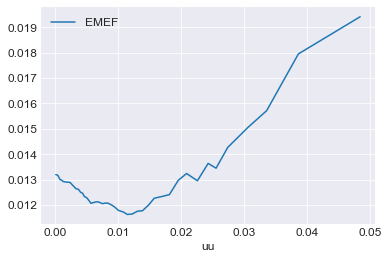

In [553]:
df = EMEF[["uu","EMEF"]].set_index("uu")
df.loc[0:].plot(grid=True)
plt.show()

In [554]:
# Find the event uu starting from which the EMEF plot is approximately linear 
theshold_uu = 0.028

# Then get the the corresponding quantile 
qtail = EMEF.loc[ EMEF.apply(lambda x: abs(x["uu"] - theshold_uu), axis=1).argmin() , "pu"]

print(f"Tail identified by x = {theshold_uu:.3f} ({qtail:.1f}%)")
#(qtail, theshold_uu)

Tail identified by x = 0.028 (95.0%)


In [555]:
u = ddf.quantile(q = qtail/100).values[0]
tail = ddf.query("{} > {}".format(tick,u))

# numero de datos de la cola vs total data (en %)
tail.shape[0] / ddf.shape[0] * 100

5.023491145645103

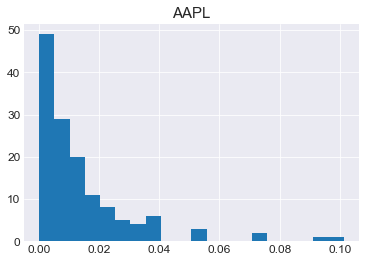

In [556]:
# Excesses
y = tail - u

y.hist(bins=20)
plt.show()

In [557]:
# Fit Generalized Pareto Distribution GDP
gdpdist = mle(y[tick].values, dist="gdp", dx=0.0005)

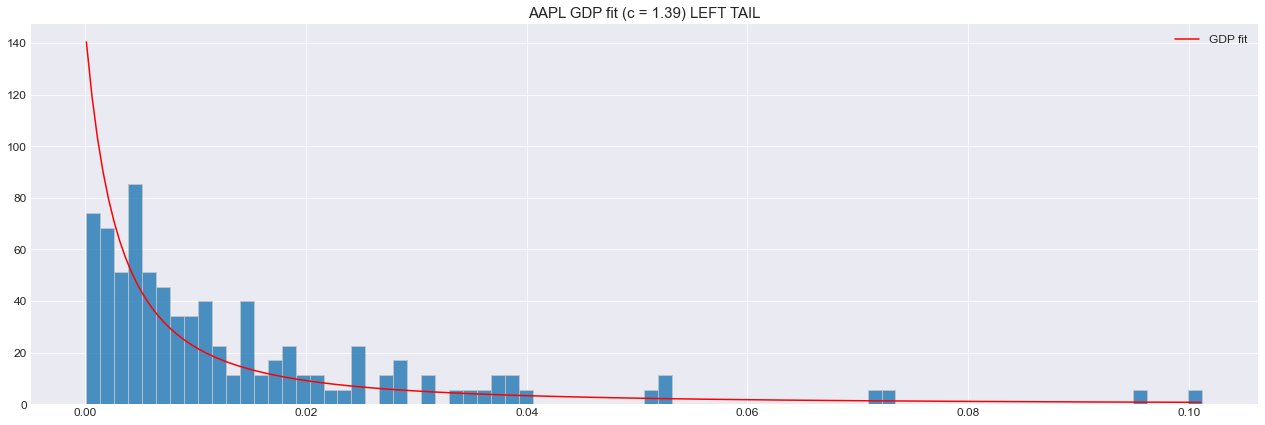

In [558]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(22, 7))
#ax = ax.flatten()
plt.subplots_adjust(wspace=0.05)
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 
bins = 80
grey = .77, .77, .77

n = 0
y.hist(ax=ax, grid=True, bins=bins, density=True, edgecolor=grey, alpha=0.8)
ax.set_title("{} GDP fit (c = {:.2f}) LEFT TAIL".format(tick,gdpdist["c"]))
ax.plot(gdpdist["x"], gdpdist["pdf"], 'r', label="GDP fit")
ax.legend(loc="best")
plt.show() 

In [559]:
# Number of exceesses
Nu = y.shape[0]

# Total number of data
N = ddf.shape[0]

# GDP tail index parameter
xi = gdpdist["c"] 
# GDP scale parameters
beta = gdpdist["std"]

CL = 99

In [560]:
# Shock de la left tail con POT 
potshock = u + (beta/xi)*( ((1-CL/100)*N/Nu)**(-xi) - 1)

# Quantile al mismo CL de los datos reales 
palmereal = ddf.quantile(q = CL/100).values[0]

# Shock positivos de la left tail (retornos negativos)
(-potshock, -palmereal)

(-0.07056839443737722, -0.04838724851850595)

In [83]:
# Using MLE to best fit a t-student distribution to P&Ls series
tdist = mle(rets, dist="t", dx=0.0005, mm=abs(rets.min()*(10/100)))

In [84]:
# Also fit a normal distribution for the sake of comparing density distributions
ndist = mle(rets, dist="n", dx=0.0005, mm=abs(rets.min()*(10/100)))

/Users/leonardorocchi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


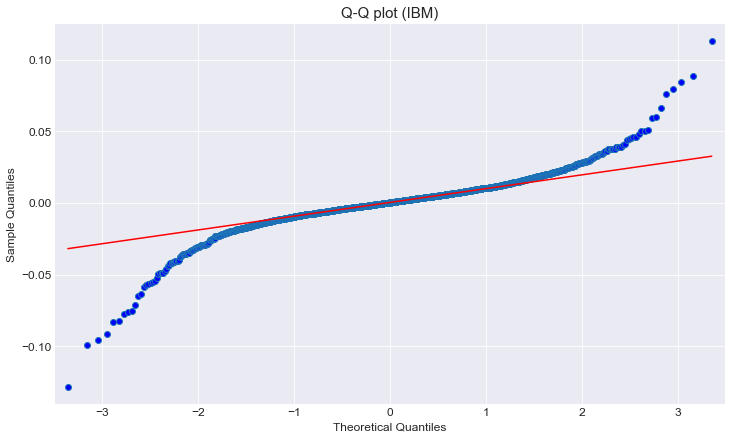

In [138]:
import statsmodels.api as sm

fig, ax = plt.subplots(1,1,figsize=(12,7))
plt.subplots_adjust(wspace=0.05)
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 

sm.qqplot(rets.values, line='q', fit=False, ax=ax, fmt='o')
ax.grid()
ax.set_title("Q-Q plot ({})".format(tick))
plt.show()

In [139]:
# Using MLE to best fit a t-student distribution to P&Ls series
tdist = mle(rets, dist="t", dx=0.0005, mm=abs(rets.min()*(10/100)))

In [140]:
print(round(tdist["mu"]*100,2), round(tdist["sigma"]*100,1), round(tdist["degf"],2))

0.04 0.8 2.79


In [141]:
# Also fit a normal distribution for the sake of comparing density distributions
ndist = mle(rets, dist="n", dx=0.0005, mm=abs(rets.min()*(10/100)))

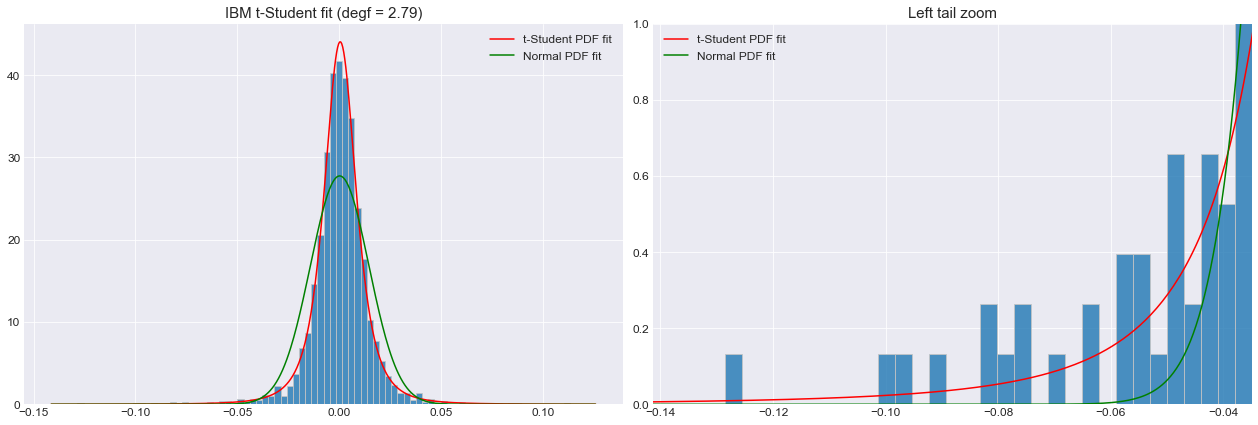

In [142]:
# Plot
fig, ax = plt.subplots(1,2,figsize=(22, 7))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.05)
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)  
plt.rc('legend', fontsize=12) 
bins = 80
grey = .77, .77, .77

n = 0
rets.hist(ax=ax[n], grid=True, bins=bins, density=True, edgecolor=grey, alpha=0.8)
ax[n].set_title("{} t-Student fit (degf = {:.2f})".format(tick,tdist["degf"]))
ax[n].plot(tdist["x"], tdist["pdf"], 'r', label="t-Student PDF fit")
ax[n].plot(ndist["x"], ndist["pdf"], 'g', label="Normal PDF fit")
ax[n].legend(loc="best")

n = n+1
rets.hist(ax=ax[n], grid=True, bins=bins, density=True, edgecolor=grey, alpha=0.8)
ax[n].plot(tdist["x"], tdist["pdf"], 'r', label="t-Student PDF fit")
ax[n].plot(ndist["x"], ndist["pdf"], 'g', label="Normal PDF fit")
ax[n].set_title("Left tail zoom")
ax[n].set_xlim([rets.min()-abs(rets.min()*(10/100)), -0.035])
ax[n].set_ylim([0, 1])
ax[n].legend(loc="best")

plt.show() 

In [143]:
fe  = get_empirical_cdf(rets)
fh1 = get_hypothetical_cdf(rets, tdist, distype="t")
fh2 = get_hypothetical_cdf(rets, ndist, distype="n")

<function matplotlib.pyplot.show(close=None, block=None)>

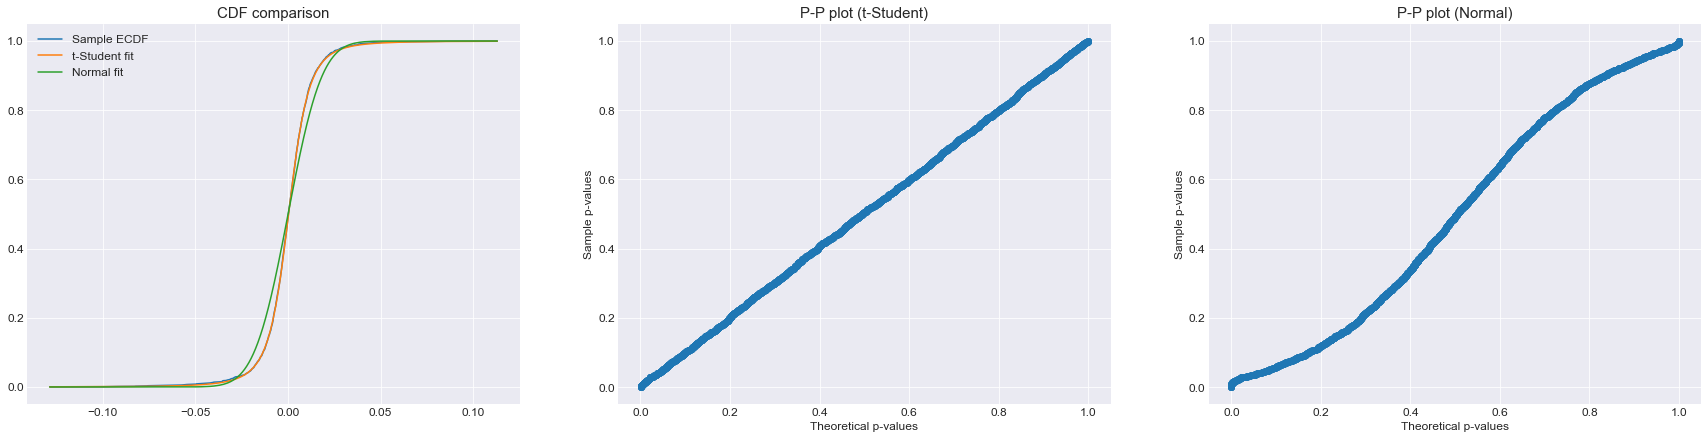

In [144]:
# Plot
fig, ax = plt.subplots(1,3,figsize=(30,7))
ax = ax.flatten()
fe.plot(ax=ax[0], label="Sample ECDF")
fh1.plot(ax=ax[0], label="t-Student fit")
fh2.plot(ax=ax[0], grid=True, label="Normal fit")
ax[0].legend()
ax[0].set_title("CDF comparison")

ax[1].scatter(fh1.values, fe.values)
ax[1].grid()
ax[1].set_xlabel("Theoretical p-values")
ax[1].set_ylabel("Sample p-values")
ax[1].set_title("P-P plot (t-Student)")


ax[2].scatter(fh2.values, fe.values)
ax[2].grid()
ax[2].set_xlabel("Theoretical p-values")
ax[2].set_ylabel("Sample p-values")
ax[2].set_title("P-P plot (Normal)")

plt.show

In [151]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF  

def get_empirical_cdf(data):
    FE = ECDF(data)    
    FE = pd.Series(FE.y, index=FE.x, name="Emprirical CDF")
    FE = FE.drop(index=FE.index[0])
    return FE

def get_hypothetical_cdf(data, FH, distype = "t"):
    if distype == "n":
        return pd.Series(np.sort(stats.norm.cdf(data, loc=FH["mu"], scale=FH["sigma"])), 
                         index=np.sort(data),
                         name="Hypothesized Normal")  
    elif distype == "t":
        return pd.Series(np.sort(stats.t.cdf(data, df=FH["degf"], loc=FH["mu"], scale=FH["sigma"])), 
                         index=np.sort(data), 
                         name="Hypothesized t-Student")
    
def test(FE, FH, testype="KS"):
    if testype == "KS":
        return max(abs( FE - FH ) ) 
    elif testype == "AD":
        return max(abs( FE - FH ).divide( np.sqrt(FH.multiply(1 - FH)) ) )

def pvalues(teststat, critval):
    return ECDF(teststat)(critval)

In [146]:
mcsamples = 1000
start = time.time()
KS, AD = mc_test_stats(tdist, size=rets.shape[0], mcsamples=mcsamples, dtype="t")
end = time.time()
print("total time: {:.5f}s".format(end-start))

total time: 32.86810s


In [152]:
F_emp_KS = get_empirical_cdf(KS)
F_emp_AD = get_empirical_cdf(AD)

In [153]:
siglevel = 5

In [154]:
criticalval_KS = np.quantile(KS, q=siglevel/100)
criticalval_AD = np.quantile(AD, q=siglevel/100)
criticalval_KS, criticalval_AD

(0.0075744393463855805, 0.027693341679841894)

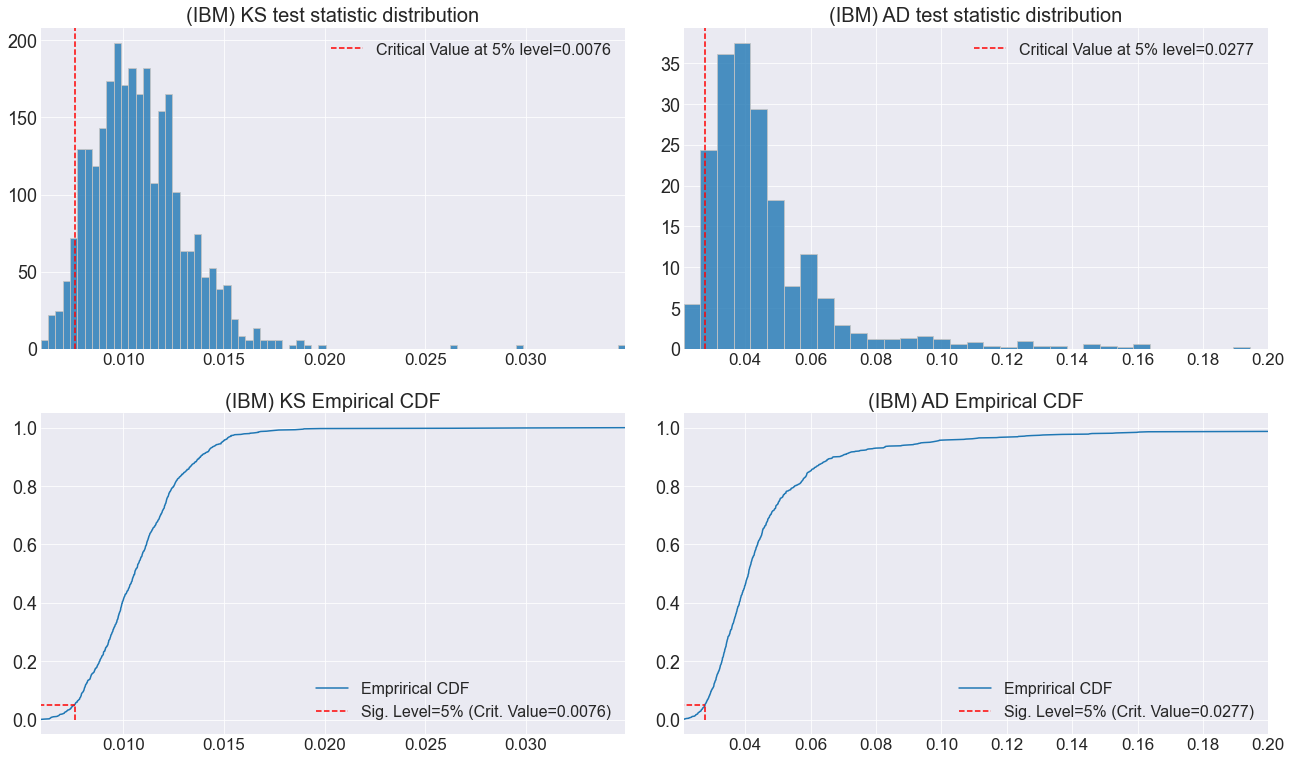

In [155]:
# Plot
fig, ax = plt.subplots(2,2,figsize=(22, 13))
ax = ax.flatten()

plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=16) 
plt.rc('xtick', labelsize=17)   
plt.rc('ytick', labelsize=18)  
plt.rc('legend', fontsize=16)  
bins = 80
grey = (.77, .77, .77)

n = 0
KS.hist(ax=ax[n], bins=bins, density=True, edgecolor=grey, alpha=0.8)
ax[n].set_title("({}) KS test statistic distribution".format(tick))
ax[n].set_xlim([KS.min(), KS.max()])
ax[n].axvline(x=criticalval_KS, linestyle="--", color="red", label="Critical Value at {:.0f}% level={:.4f}".format(siglevel, criticalval_KS))
ax[n].legend(loc="best")
#ax[n].set_xlim([0, 0.175])

n = n+1
AD.hist(ax=ax[n], bins=200, density=True, edgecolor=grey, alpha=0.8)
ax[n].set_title("({}) AD test statistic distribution".format(tick))
ax[n].set_xlim([AD.min(), AD.max()])
ax[n].axvline(x=criticalval_AD, linestyle="--", color="red", label="Critical Value at {:.0f}% level={:.4f}".format(siglevel, criticalval_AD))
ax[n].legend(loc="best")
ax[n].set_xlim([AD.min(), 0.2])


n = n+1
F_emp_KS.plot(ax=ax[n], grid=True)
ax[n].set_title("({}) KS Empirical CDF".format(tick))
ax[n].set_xlim([KS.min(), KS.max()])
ax[n].plot([criticalval_KS, criticalval_KS], [0, siglevel/100], c='red', linestyle="--") 
ax[n].plot([0, criticalval_KS], [siglevel/100, siglevel/100], c='red', linestyle="--", label="Sig. Level={:.0f}% (Crit. Value={:.4f})".format(siglevel, criticalval_KS)) 
#ax[n].plot([KS_stat, KS_stat], [0, pvalue_KS], c='green', linestyle="--") 
#ax[n].plot([0, KS_stat], [pvalue_KS, pvalue_KS], c='green', linestyle="--", label="p-value={:.0f}% (KS statistic={:.4f})".format(pvalue_KS*100, KS_stat)) 
ax[n].legend(loc="best")
#ax[n].set_xlim([0, 0.175])


n = n+1
F_emp_AD.plot(ax=ax[n], grid=True)
ax[n].set_title("({}) AD Empirical CDF".format(tick))
ax[n].set_xlim([AD.min(), AD.max()])
ax[n].plot([criticalval_AD, criticalval_AD], [0, siglevel/100], c='red', linestyle="--") 
ax[n].plot([0, criticalval_AD], [siglevel/100, siglevel/100], c='red', linestyle="--", label="Sig. Level={:.0f}% (Crit. Value={:.4f})".format(siglevel, criticalval_AD)) 
#ax[n].plot([AD_stat, AD_stat], [0, pvalue_AD], c='green', linestyle="--") 
#ax[n].plot([0, AD_stat], [pvalue_AD, pvalue_AD], c='green', linestyle="--", label="p-value={:.0f}% (AD statistic={:.4f})".format(pvalue_AD*100, AD_stat)) 
ax[n].legend(loc="best")
ax[n].set_xlim([AD.min(), 0.2])

plt.show()

In [156]:
# FE and # FH
FE = get_empirical_cdf(rets)
FH = get_hypothetical_cdf(rets, tdist, distype="t")
# Critical values
test_KS = test(FE, FH, testype="KS")
test_AD = test(FE, FH, testype="AD")   
# p-values
pvalue_KS = pvalues(KS, test_KS)
pvalue_AD = pvalues(AD, test_AD)

In [157]:
round(test_KS,4), round(test_AD,4)

(0.0089, 0.0431)

In [158]:
pvalue_KS*100, pvalue_AD*100

(20.700000000000003, 58.099999999999994)

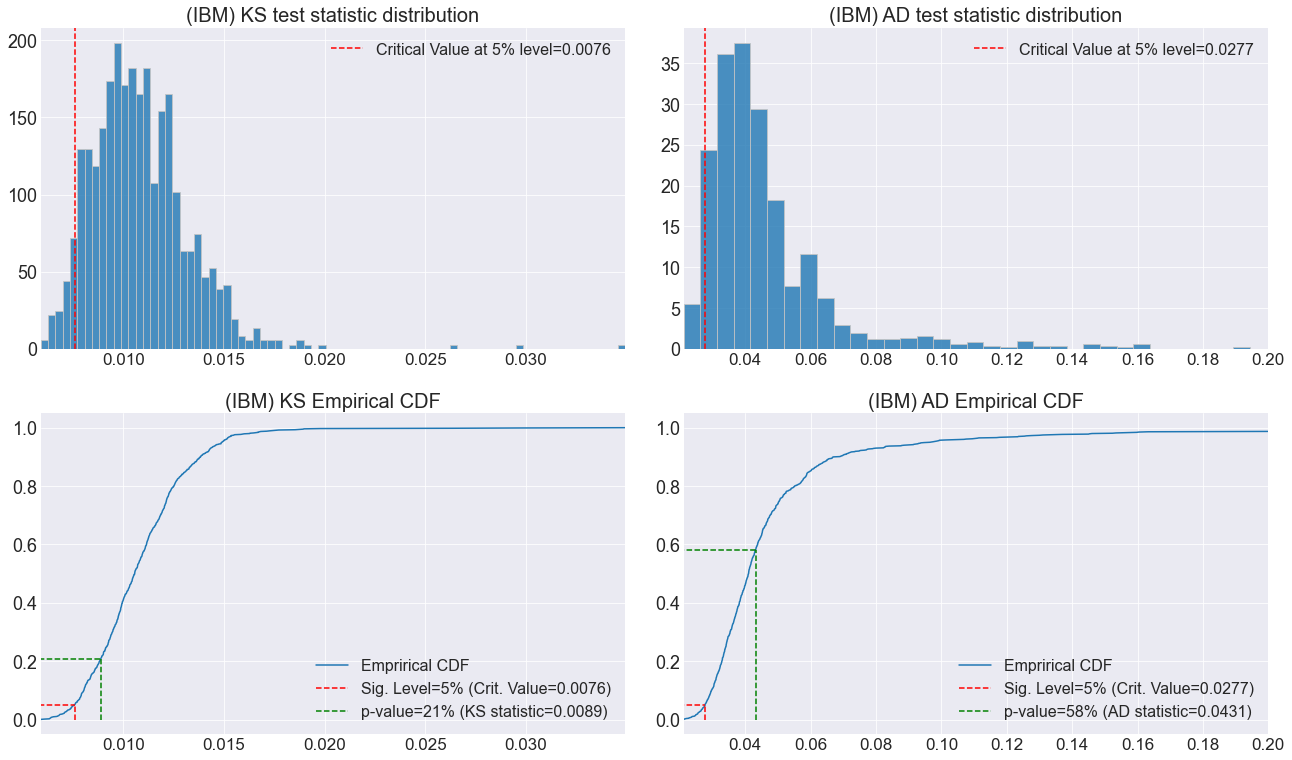

In [159]:
# Plot
fig, ax = plt.subplots(2,2,figsize=(22, 13))
ax = ax.flatten()

plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=16) 
plt.rc('xtick', labelsize=17)   
plt.rc('ytick', labelsize=18)  
plt.rc('legend', fontsize=16)  
bins = 80
grey = (.77, .77, .77)

n = 0
KS.hist(ax=ax[n], bins=bins, density=True, edgecolor=grey, alpha=0.8)
ax[n].set_title("({}) KS test statistic distribution".format(tick))
ax[n].set_xlim([KS.min(), KS.max()])
ax[n].axvline(x=criticalval_KS, linestyle="--", color="red", label="Critical Value at {:.0f}% level={:.4f}".format(siglevel, criticalval_KS))
ax[n].legend(loc="best")
#ax[n].set_xlim([0, 0.175])

n = n+1
AD.hist(ax=ax[n], bins=200, density=True, edgecolor=grey, alpha=0.8)
ax[n].set_title("({}) AD test statistic distribution".format(tick))
ax[n].set_xlim([AD.min(), AD.max()])
ax[n].axvline(x=criticalval_AD, linestyle="--", color="red", label="Critical Value at {:.0f}% level={:.4f}".format(siglevel, criticalval_AD))
ax[n].legend(loc="best")
ax[n].set_xlim([AD.min(), 0.2])


n = n+1
F_emp_KS.plot(ax=ax[n], grid=True)
ax[n].set_title("({}) KS Empirical CDF".format(tick))
ax[n].set_xlim([KS.min(), KS.max()])
ax[n].plot([criticalval_KS, criticalval_KS], [0, siglevel/100], c='red', linestyle="--") 
ax[n].plot([0, criticalval_KS], [siglevel/100, siglevel/100], c='red', linestyle="--", label="Sig. Level={:.0f}% (Crit. Value={:.4f})".format(siglevel, criticalval_KS)) 
ax[n].plot([test_KS, test_KS], [0, pvalue_KS], c='green', linestyle="--") 
ax[n].plot([0, test_KS], [pvalue_KS, pvalue_KS], c='green', linestyle="--", label="p-value={:.0f}% (KS statistic={:.4f})".format(pvalue_KS*100, test_KS)) 
ax[n].legend(loc="best")
#ax[n].set_xlim([0, 0.175])


n = n+1
F_emp_AD.plot(ax=ax[n], grid=True)
ax[n].set_title("({}) AD Empirical CDF".format(tick))
ax[n].set_xlim([AD.min(), AD.max()])
ax[n].plot([criticalval_AD, criticalval_AD], [0, siglevel/100], c='red', linestyle="--") 
ax[n].plot([0, criticalval_AD], [siglevel/100, siglevel/100], c='red', linestyle="--", label="Sig. Level={:.0f}% (Crit. Value={:.4f})".format(siglevel, criticalval_AD)) 
ax[n].plot([test_AD, test_AD], [0, pvalue_AD], c='green', linestyle="--") 
ax[n].plot([0, test_AD], [pvalue_AD, pvalue_AD], c='green', linestyle="--", label="p-value={:.0f}% (AD statistic={:.4f})".format(pvalue_AD*100, test_AD)) 
ax[n].legend(loc="best")
ax[n].set_xlim([AD.min(), 0.2])

plt.show()

In [ ]:
# repeat the same experiment with the hypothesis of normality.
# Pero en este caso la null hypothesis será
# H0 = la distribuzione non e normale
# H1 = la distribuzione e normale

In [118]:
mcsamples = 1000
start = time.time()
KS, AD = mc_test_stats(ndist, size=rets.shape[0], mcsamples=mcsamples, dtype="n")
end = time.time()
print("total time: {:.5f}s".format(end-start))

total time: 2.29508s


In [119]:
F_emp_KS = get_empirical_cdf(KS)

In [120]:
F_emp_AD = get_empirical_cdf(AD)

In [121]:
siglevel = 5

In [122]:
criticalval_KS = np.quantile(KS, q=siglevel/100)
criticalval_AD = np.quantile(AD, q=siglevel/100)
criticalval_KS, criticalval_AD

(0.00826394350137762, 0.028021021914215457)

In [123]:
# FE and # FH
FE = get_empirical_cdf(rets)
FH = get_hypothetical_cdf(rets, ndist, distype="n")
# Critical values
test_KS = test(FE, FH, testype="KS")
test_AD = test(FE, FH, testype="AD")   
# p-values
pvalue_KS = pvalues(KS, test_KS)
pvalue_AD = pvalues(AD, test_AD)

In [125]:
round(test_KS,4), round(test_AD,4)

(0.0946, 939258.1493)

In [126]:
pvalue_KS*100, pvalue_AD*100

(100.0, 100.0)

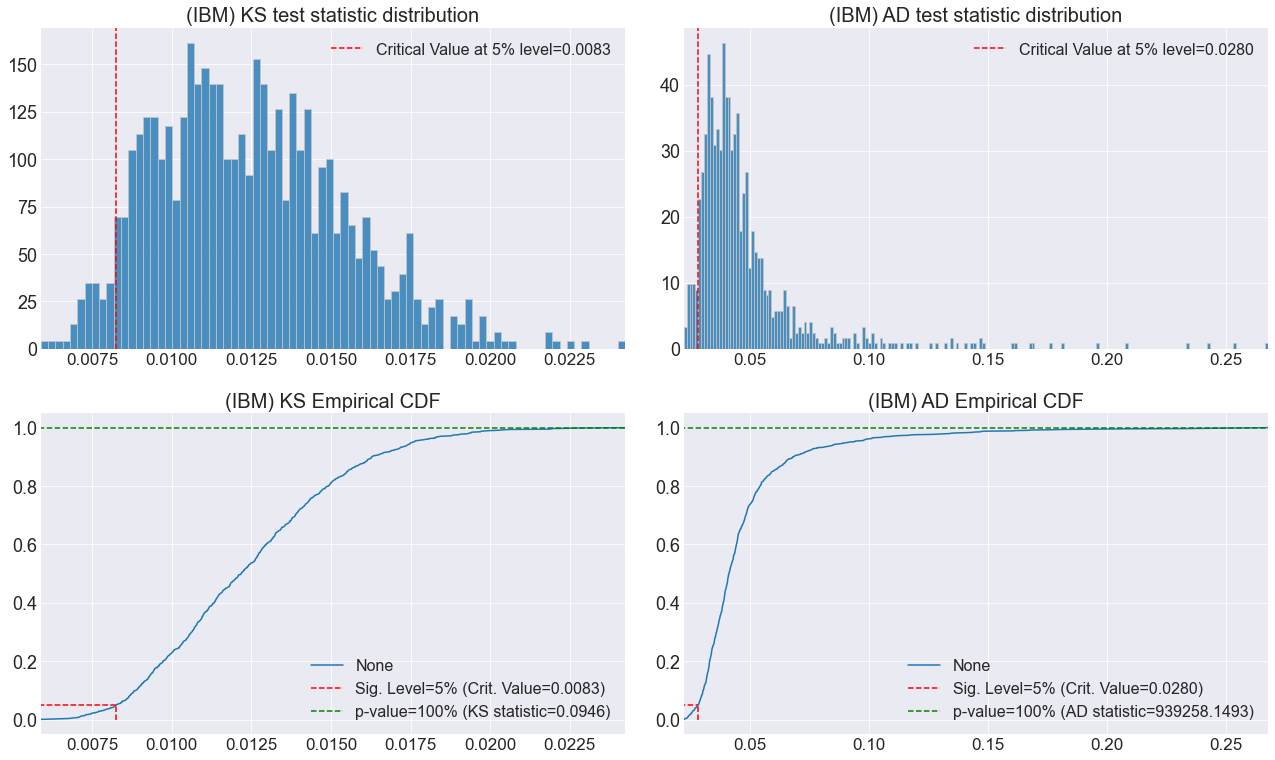

In [127]:
# Plot
fig, ax = plt.subplots(2,2,figsize=(22, 13))
ax = ax.flatten()

plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=16) 
plt.rc('xtick', labelsize=17)   
plt.rc('ytick', labelsize=18)  
plt.rc('legend', fontsize=16)  
bins = 80
grey = (.77, .77, .77)

n = 0
KS.hist(ax=ax[n], bins=bins, density=True, edgecolor=grey, alpha=0.8)
ax[n].set_title("({}) KS test statistic distribution".format(tick))
ax[n].set_xlim([KS.min(), KS.max()])
ax[n].axvline(x=criticalval_KS, linestyle="--", color="red", label="Critical Value at {:.0f}% level={:.4f}".format(siglevel, criticalval_KS))
ax[n].legend(loc="best")
#ax[n].set_xlim([0, 0.175])

n = n+1
AD.hist(ax=ax[n], bins=200, density=True, edgecolor=grey, alpha=0.8)
ax[n].set_title("({}) AD test statistic distribution".format(tick))
ax[n].set_xlim([AD.min(), AD.max()])
ax[n].axvline(x=criticalval_AD, linestyle="--", color="red", label="Critical Value at {:.0f}% level={:.4f}".format(siglevel, criticalval_AD))
ax[n].legend(loc="best")
#ax[n].set_xlim([AD.min(), 0.2])


n = n+1
F_emp_KS.plot(ax=ax[n], grid=True)
ax[n].set_title("({}) KS Empirical CDF".format(tick))
ax[n].set_xlim([KS.min(), KS.max()])
ax[n].plot([criticalval_KS, criticalval_KS], [0, siglevel/100], c='red', linestyle="--") 
ax[n].plot([0, criticalval_KS], [siglevel/100, siglevel/100], c='red', linestyle="--", label="Sig. Level={:.0f}% (Crit. Value={:.4f})".format(siglevel, criticalval_KS)) 
ax[n].plot([test_KS, test_KS], [0, pvalue_KS], c='green', linestyle="--") 
ax[n].plot([0, test_KS], [pvalue_KS, pvalue_KS], c='green', linestyle="--", label="p-value={:.0f}% (KS statistic={:.4f})".format(pvalue_KS*100, test_KS)) 
ax[n].legend(loc="best")
#ax[n].set_xlim([0, 0.175])


n = n+1
F_emp_AD.plot(ax=ax[n], grid=True)
ax[n].set_title("({}) AD Empirical CDF".format(tick))
ax[n].set_xlim([AD.min(), AD.max()])
ax[n].plot([criticalval_AD, criticalval_AD], [0, siglevel/100], c='red', linestyle="--") 
ax[n].plot([0, criticalval_AD], [siglevel/100, siglevel/100], c='red', linestyle="--", label="Sig. Level={:.0f}% (Crit. Value={:.4f})".format(siglevel, criticalval_AD)) 
ax[n].plot([test_AD, test_AD], [0, pvalue_AD], c='green', linestyle="--") 
ax[n].plot([0, test_AD], [pvalue_AD, pvalue_AD], c='green', linestyle="--", label="p-value={:.0f}% (AD statistic={:.4f})".format(pvalue_AD*100, test_AD)) 
ax[n].legend(loc="best")
#ax[n].set_xlim([AD.min(), 0.2])

plt.show()

In [ ]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(22,7))
FE.plot(ax=ax)
FH.plot(ax=ax)
plt.show

# Plot
fig, ax = plt.subplots(1,1,figsize=(22,7))
ax.scatter(FE.values, FH.values)
plt.show

In [ ]:
FH